# Decision Tree Model
## Model 2

# Imports 

In [92]:
# Imports
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
6,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
7,"['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


# Data Prep

In [94]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_education_new_Bachelor,person_education_new_Graduate,person_education_new_High School,person_home_ownership_new_Non-Homeowner,loan_status
0,22,0,16.02,0.49,3,561,11.183713,10.463132,0,0,0,0,1,0,0,0,1,0,1,1
1,21,0,11.14,0.08,2,504,9.415971,6.908755,0,1,0,0,0,0,1,0,0,1,0,0
2,25,3,12.87,0.44,3,635,9.428592,8.612685,0,0,0,1,0,0,0,0,0,1,0,1
3,23,0,15.23,0.44,2,675,11.286702,10.463132,0,0,0,1,0,0,0,1,0,0,1,1
4,24,1,14.27,0.53,4,586,11.099469,10.463132,1,0,0,1,0,0,0,0,1,0,1,1


In [95]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


In [ ]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})


Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


# SMOTE 

In [98]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})


# Models


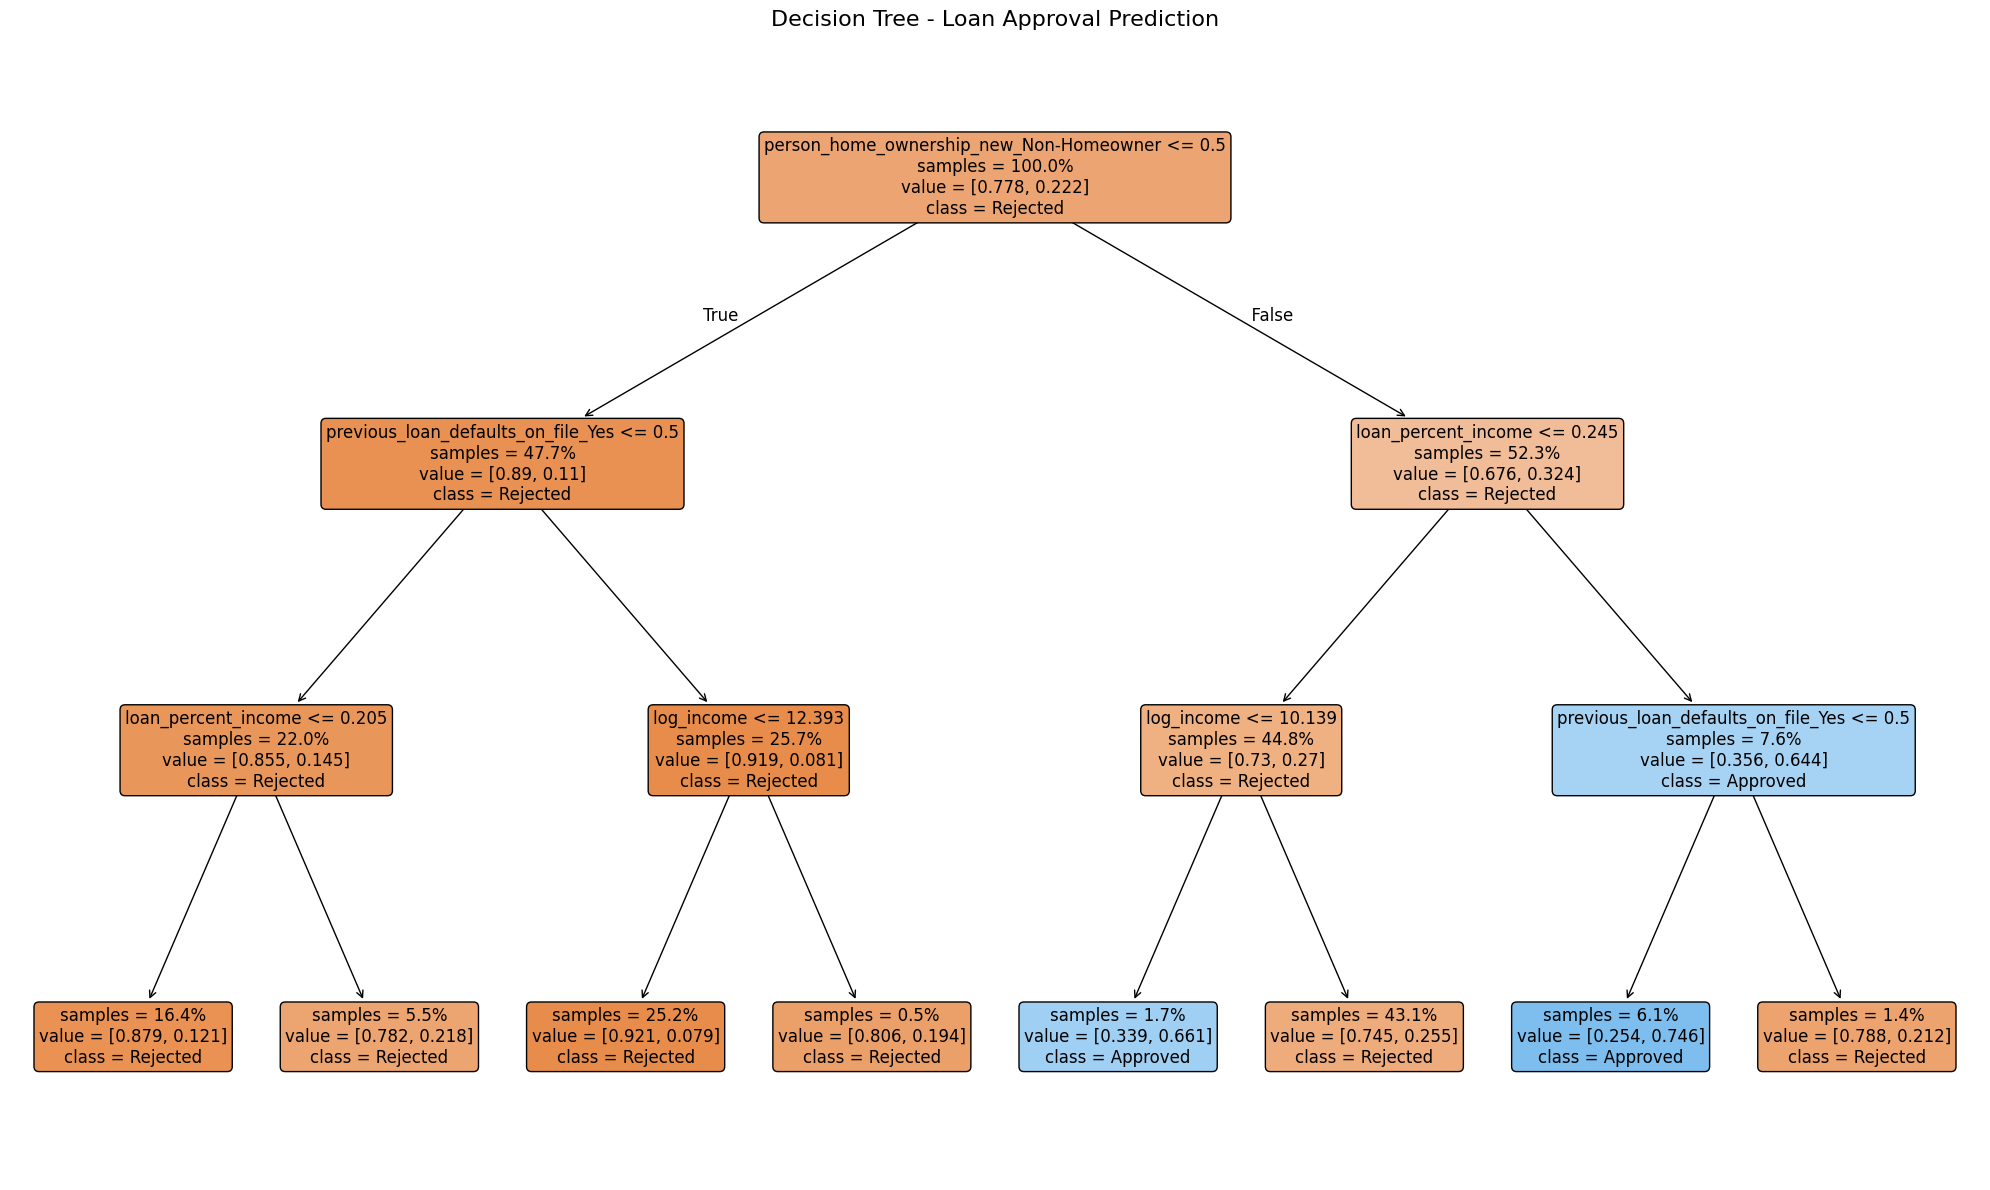

In [99]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
dt_model.fit(X_train, y_train)


# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()

**Most loan applications are rejected**
Based on the decision tree above, approval is mainly given to a small portion of non-homeowners who have high income and no previous loan defaults. For homeowners, even if they don't have prior defaults, the likelihood of rejection remains high, especially if their loan amount is large relative to their income or their income is not very high. Overall, previous loan defaults, loan burden (loan_percent_income), and income level are the strongest factors influencing the final decision, with clean credit history and strong income being critical for approval.

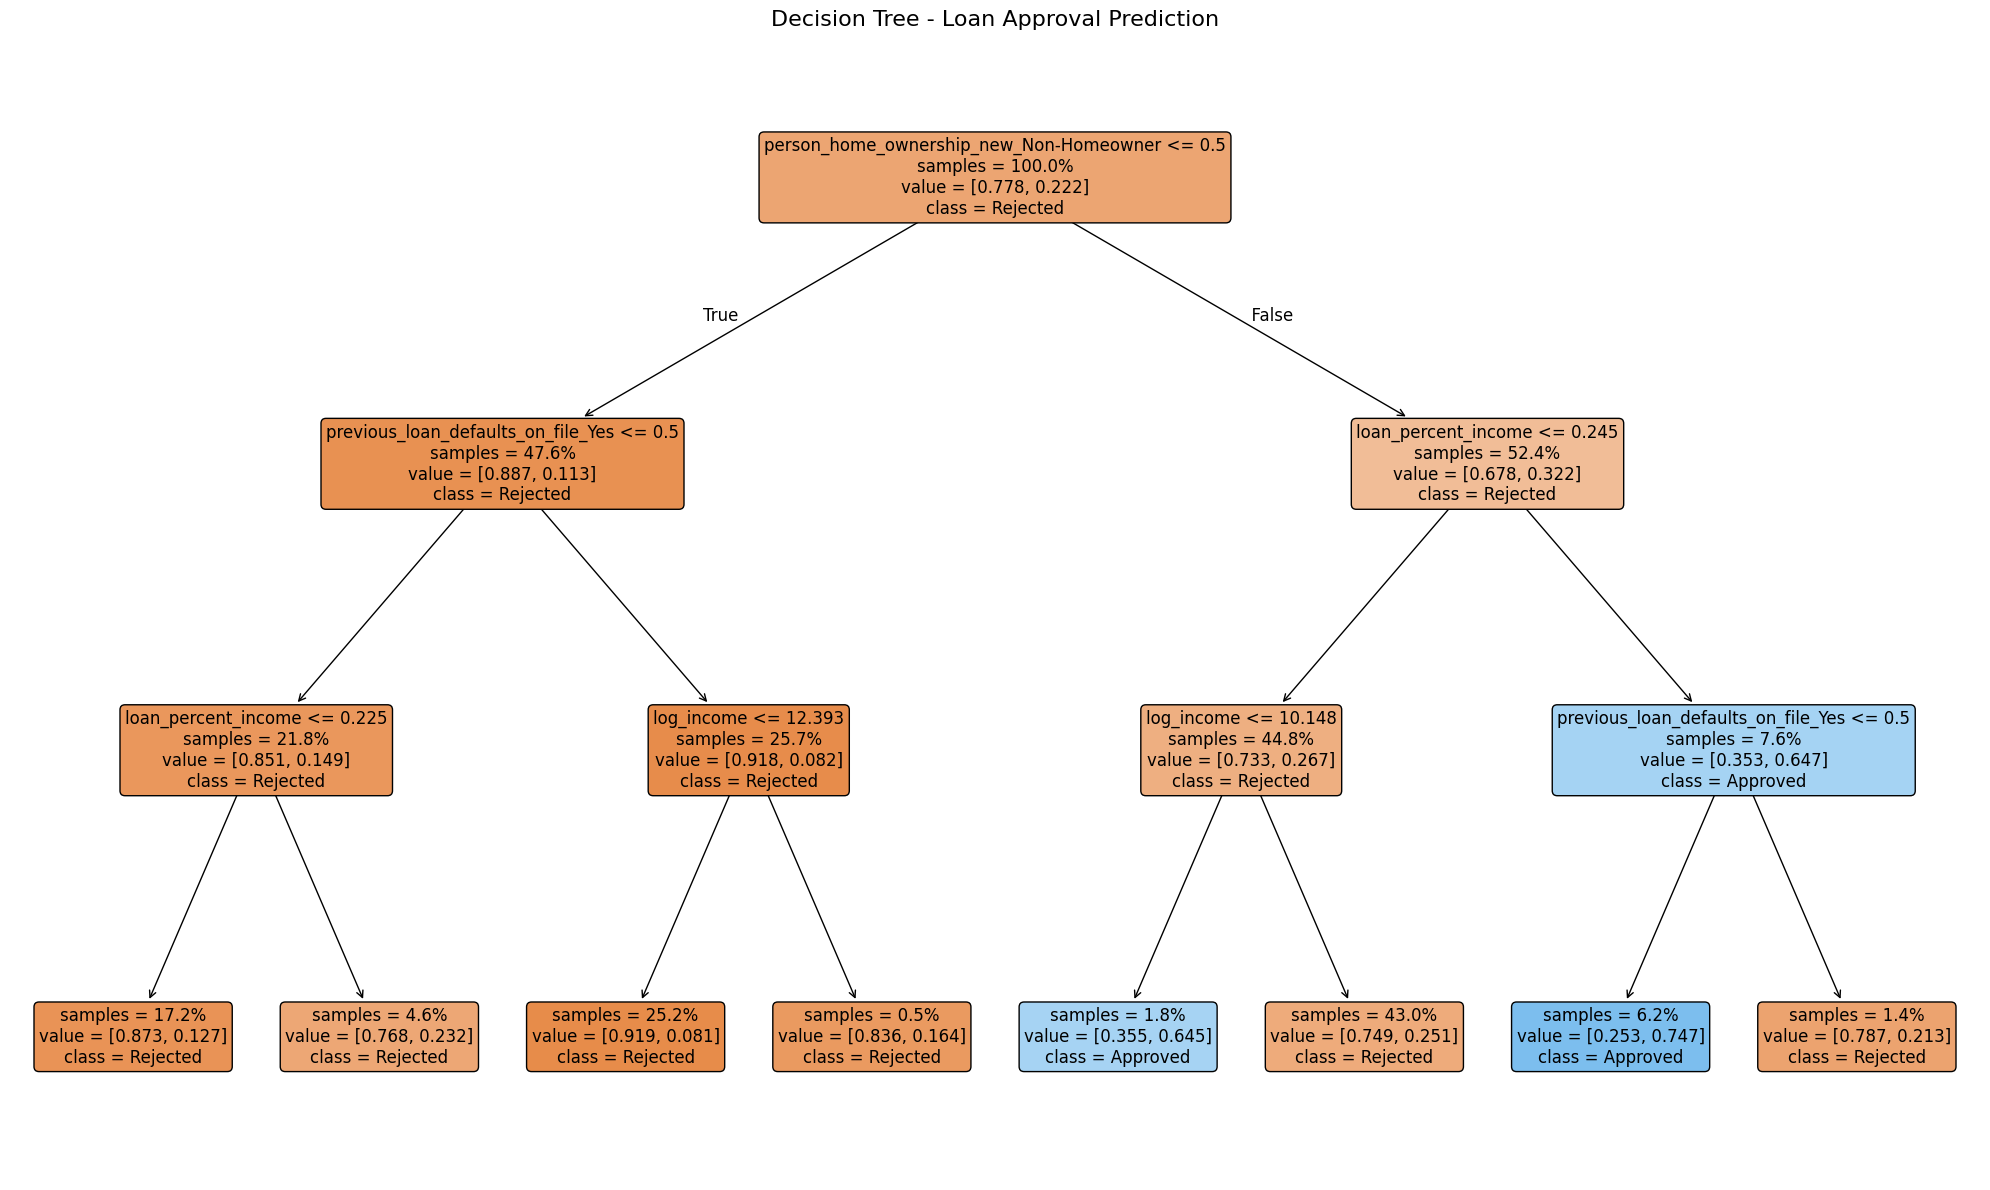

In [100]:
# Train/test split on SMOTE
X_smote = df.drop(columns=['loan_status'])
y_smote = df['loan_status']
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)



# Decision Tree
smote_dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
smote_dt_model.fit(X_smote_train, y_smote_train)

# Visualize the Decision Tree

# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(smote_dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()

dt_smote_cv_scores = cross_val_score(smote_dt_model, X_smote_train, y_smote_train, cv=5, scoring='accuracy')



After applying SMOTE, the Decision Tree Model shows a more balanced structure. There are more branches that lead to "Approved" decisions, and the value distributions in nodes are closer to being balanced between approval and rejection. This demonstrates that applying SMOTE helped the decision tree better learn patterns for both classes, leading to improved classification of approved loans and reducing the model’s bias towards rejection.


--- Base Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.82      0.97      0.89     10499
    Approved       0.74      0.27      0.39      2999

    accuracy                           0.82     13498
   macro avg       0.78      0.62      0.64     13498
weighted avg       0.81      0.82      0.78     13498



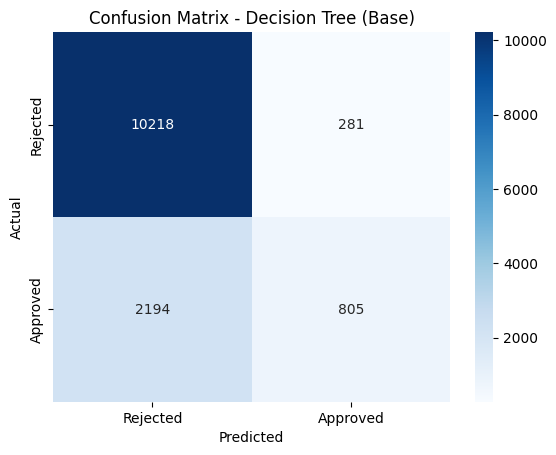

In [101]:
# --- Model Validation ---

# Evaluate base models on the test set
print("\n--- Base Model Evaluation ---")

# Decision Tree
dt_predictions = dt_model.predict(X_test)
print("\nDecision Tree:")
print(classification_report(y_test, dt_predictions, target_names=['Rejected', 'Approved']))
cm_dt = confusion_matrix(y_test, dt_predictions)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Base)')
plt.show()

The Decision Tree model demonstrates strong performance in predicting the "Rejected" class, with a precision of 0.82 and an exceptionally high recall of 0.97, leading to a solid f1-score of 0.89. This indicates that the model is very good at correctly identifying rejected loan applications. However, its performance on the "Approved" class is much weaker, with a precision of 0.74 but a low recall of 0.27 and an f1-score of only 0.39. This shows that the model struggles to correctly identify approved loans, often misclassifying them as rejections. Although the overall accuracy is 82%, it is heavily biased toward the majority "Rejected" class. The macro averages, particularly a recall of 0.62 and an f1-score of 0.64, highlight this imbalance, suggesting the model is not equally effective for both classes.


--- SMOTE DT Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.82      0.98      0.89      7007
    Approved       0.75      0.26      0.39      1992

    accuracy                           0.82      8999
   macro avg       0.79      0.62      0.64      8999
weighted avg       0.81      0.82      0.78      8999



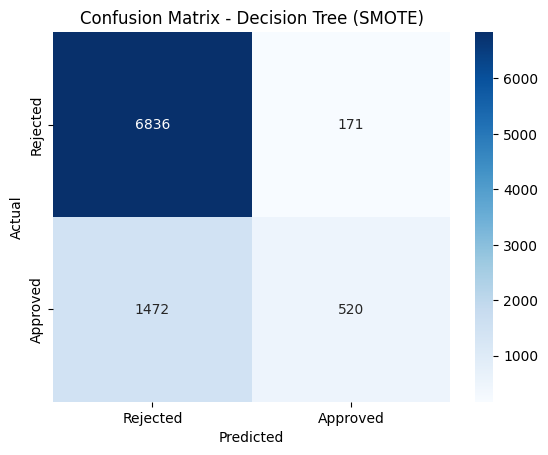

In [102]:
# SMOTE Decision Tree Evaluation
print("\n--- SMOTE DT Model Evaluation ---")

# Decision Tree
smote_dt_predictions = smote_dt_model.predict(X_smote_test)
print("\nDecision Tree:")
print(classification_report(y_smote_test, smote_dt_predictions, target_names=['Rejected', 'Approved']))

smote_cm_dt = confusion_matrix(y_smote_test, smote_dt_predictions)
sns.heatmap(smote_cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (SMOTE)')
plt.show()

The SMOTE Decision Tree model again shows strong performance on the "Rejected" class, with a precision of 0.82 and a very high recall of 0.98, resulting in an f1-score of 0.89. For the "Approved" class, however, performance remains poor, with a precision of 0.75 but a very low recall of 0.26 and an f1-score of just 0.39. This pattern indicates that the model continues to heavily favor predicting rejections while missing a large portion of approvals.

In [103]:
# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=42),
                                X_train, y_train, cv=5, scoring='accuracy')
print("\Decision Tree Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV Accuracy':<20}")
print(f"{'Original':<20}{dt_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{dt_smote_cv_scores.mean():<20.4f}")


<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Jeb Besecker\AppData\Local\Temp\ipykernel_4896\735646920.py:4: SyntaxWarning: invalid escape sequence '\D'
  print("\Decision Tree Cross-Validation Comparison:")


\Decision Tree Cross-Validation Comparison:
Dataset             Mean CV Accuracy    
Original            0.8132              
SMOTE               0.8129              


In [104]:
print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)
dt_best_model = dt_grid_search.best_estimator_


--- Hyperparameter Tuning using Grid Search CV ---

Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10499
           1       0.74      0.27      0.39      2999

    accuracy                           0.82     13498
   macro avg       0.78      0.62      0.64     13498
weighted avg       0.81      0.82      0.78     13498



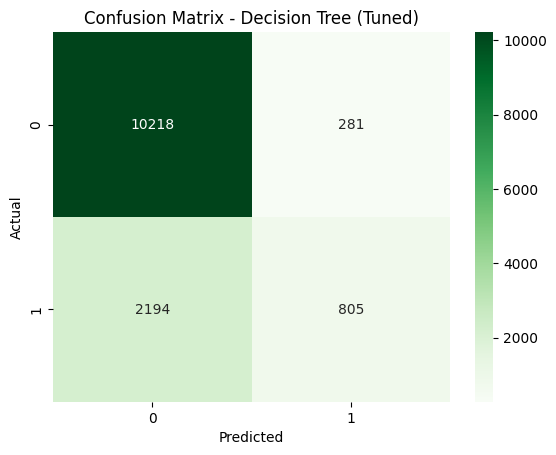

In [105]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_predictions = dt_best_model.predict(X_test)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Tuned)')
plt.show()



--- Learning Curve ---


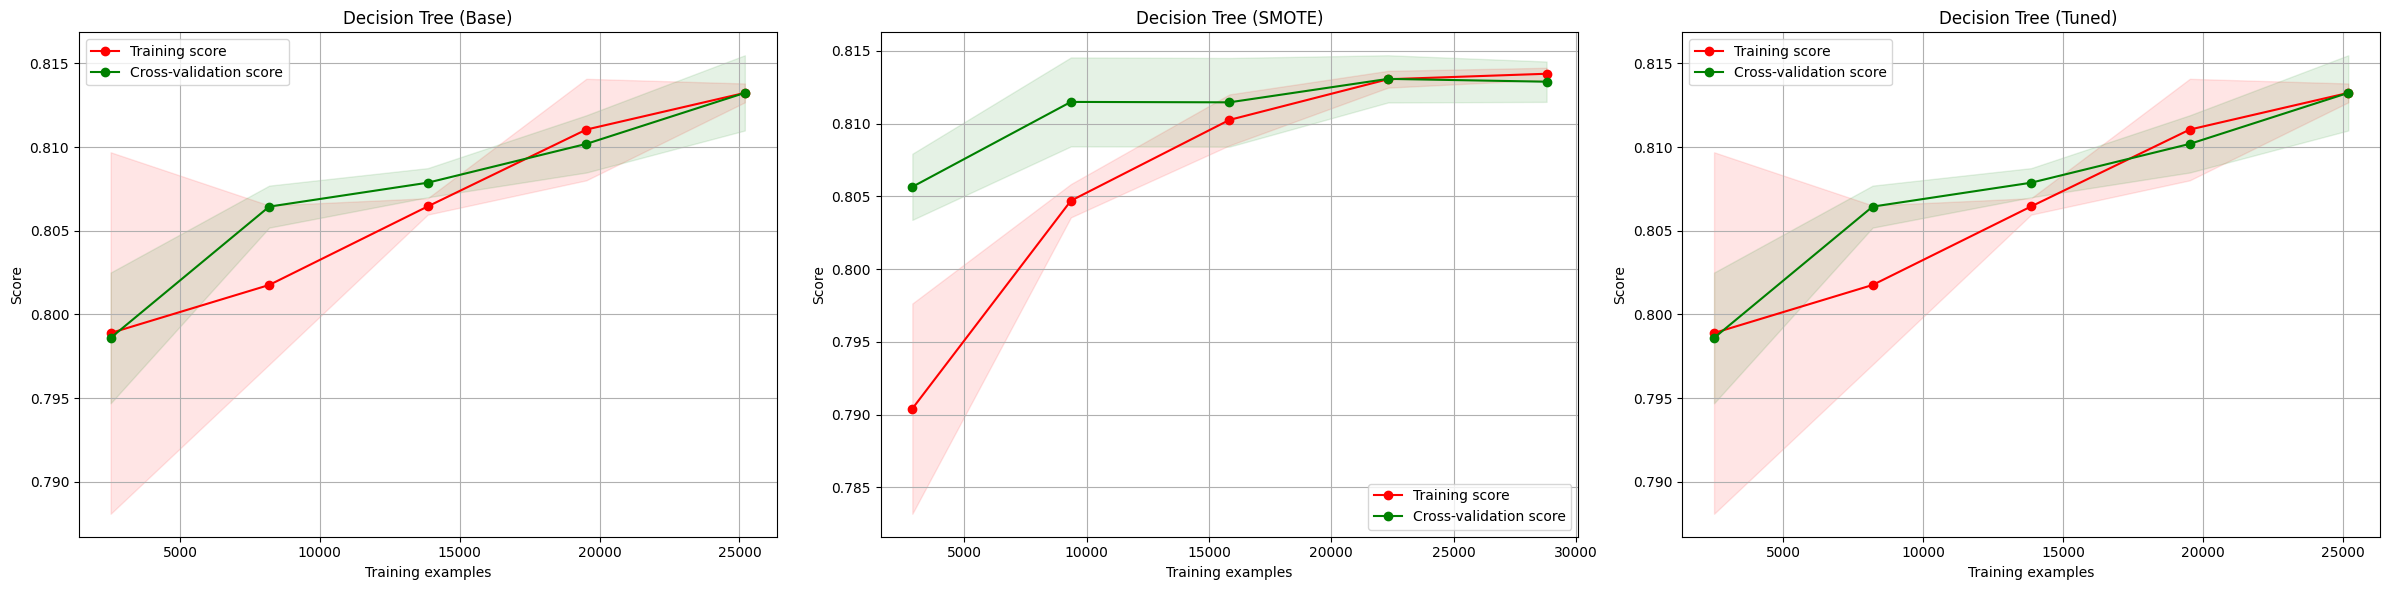

In [106]:
# --- Learning Curve ---

print("\n--- Learning Curve ---")

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

# Plot learning curves for different models
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# Original
plot_learning_curve(DecisionTreeClassifier(max_depth=3, random_state=42),
                    "Decision Tree (Base)",  
                    X_train, y_train, axes=axes[0], cv=5)

# SMOTE
plot_learning_curve(DecisionTreeClassifier(max_depth=3, random_state=42),
                    "Decision Tree (SMOTE)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# Tuned model
plot_learning_curve(dt_best_model, 
                    "Decision Tree (Tuned) ", 
                    X_train, y_train, axes=axes[2], cv=5)

plt.tight_layout()
plt.show()

